In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deploying a RAG + LangGraph Application with Cloud SQL for Postgres with Reasoning Engine with on Vertex AI

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_langgraph_cloud_sql_pg_rag_agent.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Freasoning-engine%2Ftutorial_langgraph_cloud_sql_pg_rag_agent.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_langgraph_cloud_sql_pg_rag_agent.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/reasoning-engine/tutorial_langgraph_cloud_sql_pg_rag_agent.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Xiaolong Yang](https://github.com/shawn-yang-google) |

## Overview

[Reasoning Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) (LangChain on Vertex AI) is a managed service in Vertex AI that helps you to build and deploy an agent reasoning framework. It gives you the flexibility to choose how much reasoning you want to delegate to the LLM and how much you want to handle with customized code.

RAG (Retrieval-Augmented Generation) is an AI framework that combines the strengths of traditional information retrieval systems (such as databases) with the capabilities of generative large language models (LLMs).  

[LangGraph](https://langchain-ai.github.io/langgraph/) is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.

This notebook demonstrates how to build, deploy, and test a LangGraph + RAG application using [Reasoning Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) in Vertex AI.


## Context

In previous tutorials:
* [LangGraph application with Reasoning Engine](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_langgraph.ipynb?)
You have learned how to combine LangGraph's workflow orchestration with the scalability of Vertex AI, which enables you to build custom generative AI applications.
* [RAG application with Reasoning Engine and Cloud SQL for PostgreSQL](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_cloud_sql_pg_rag_agent.ipynb)
By combining this extra knowledge with its own language skills, the AI can write text that is more accurate, up-to-date, and relevant to your specific needs.
Your [LangChain](https://python.langchain.com/docs/get_started/introduction) agent uses an [Postgres Vector Store](https://github.com/googleapis/langchain-google-cloud-sql-pg-python/tree/main) to perform a similary search and retrieve related data to ground the LLM response.

## Objectives

In this tutorial, you will learn how to build and deploy an agent (model, tools, and reasoning) using the Vertex AI SDK for Python and Cloud SQL for PostgreSQL LangGraph integration.

You will develop a LangGraph Application like:
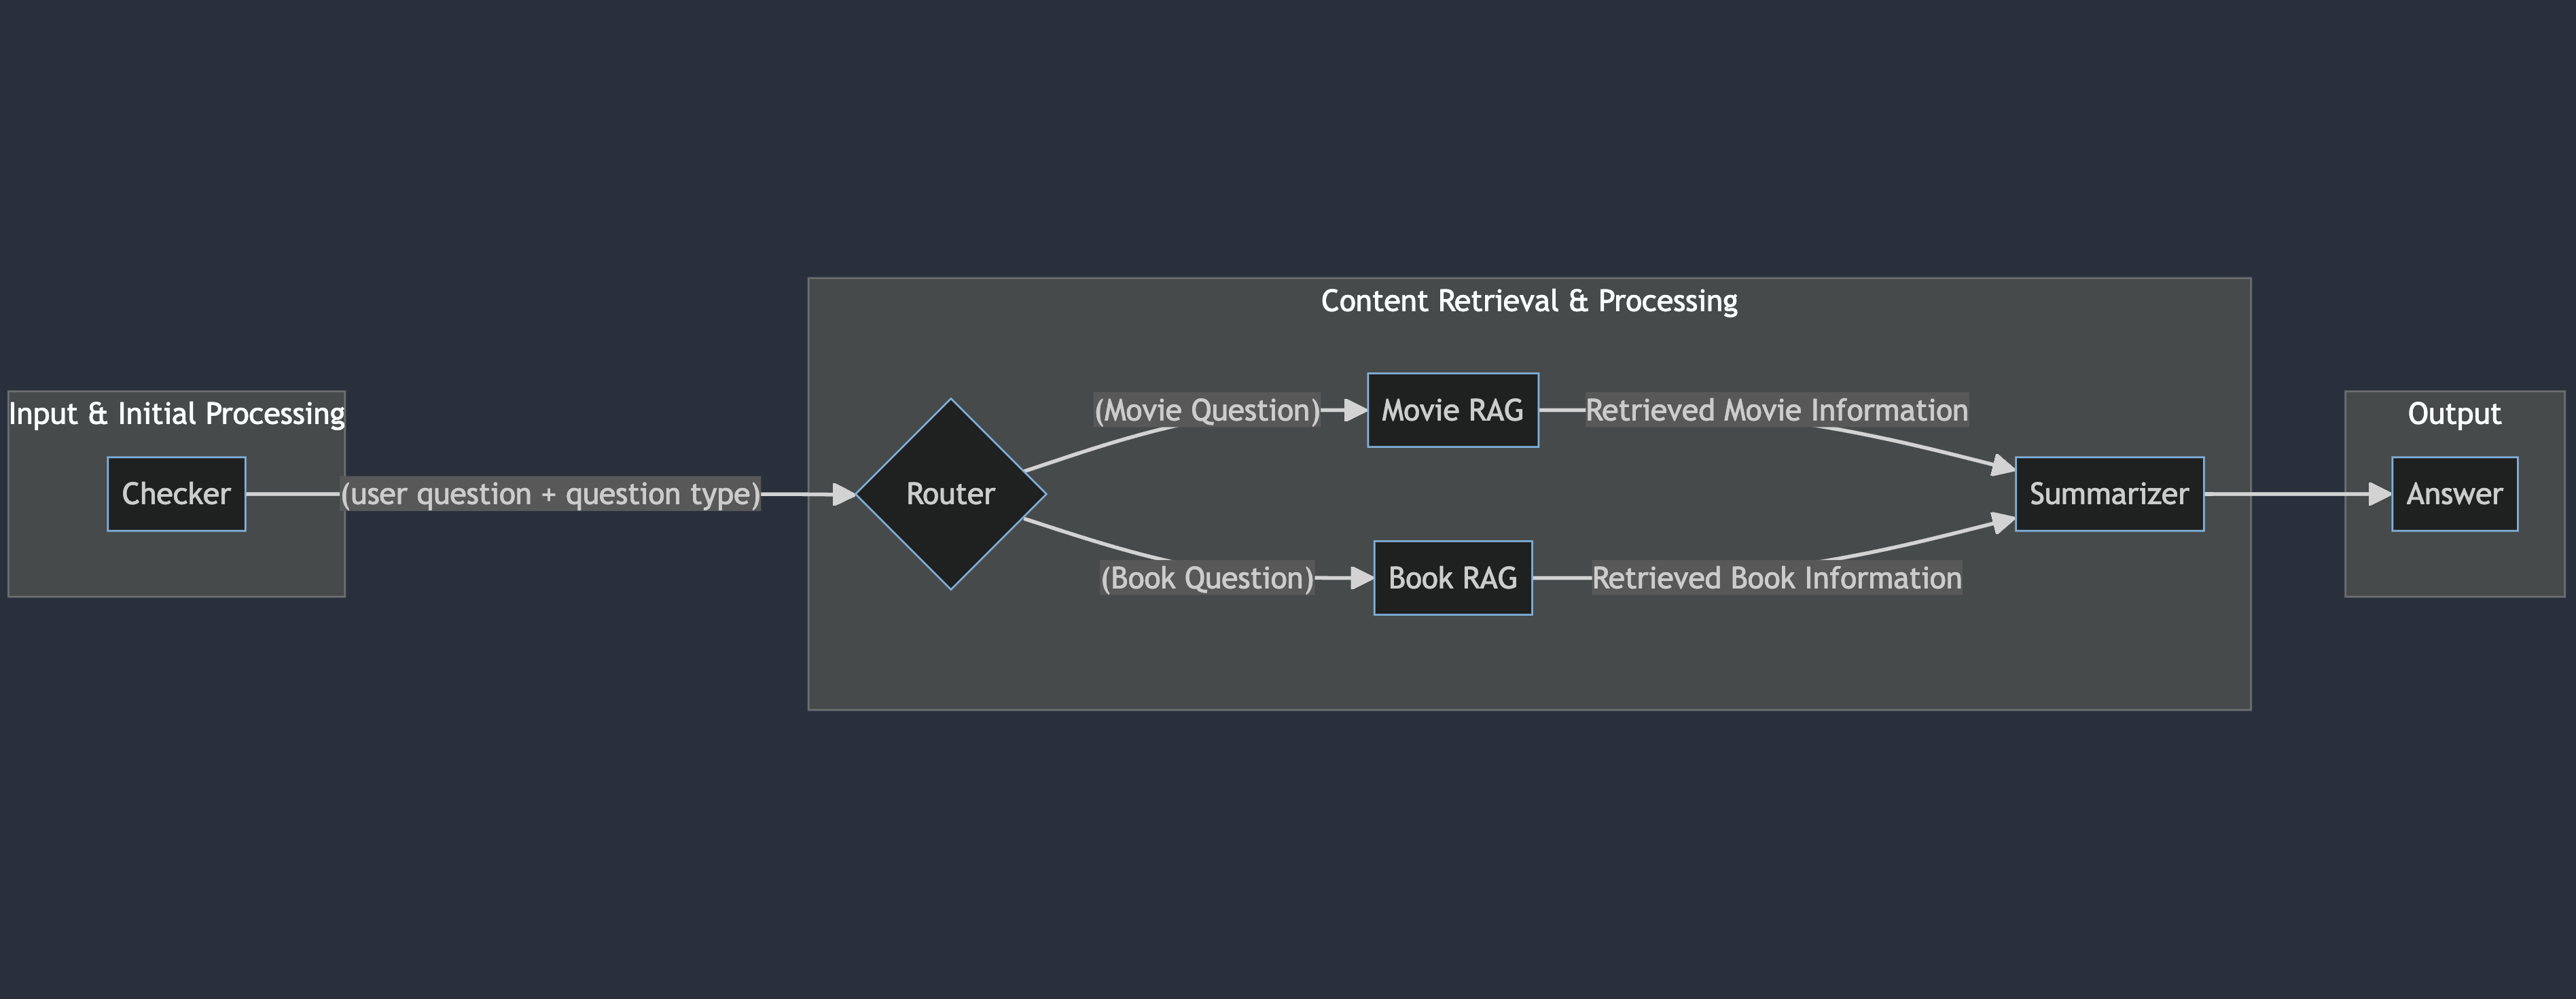


## Before you begin

1. In the Google Cloud console, on the project selector page, select or [create a Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects).
2. [Make sure that billing is enabled for your Google Cloud project](https://cloud.google.com/billing/docs/how-to/verify-billing-enabled#console).
3. Follow the instruction in [RAG application with Reasoning Engine and Cloud SQL for PostgreSQL](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_cloud_sql_pg_rag_agent.ipynb), set up Cloud SQL for PostgreSQL.

### Required roles

To get the permissions that you need to complete the tutorial, ask your administrator to grant you the [Owner](https://cloud.google.com/iam/docs/understanding-roles#owner) (`roles/owner`) IAM role on your project. For more information about granting roles, see [Manage access](https://cloud.google.com/iam/docs/granting-changing-revoking-access).


### Install and import dependencies

In [ ]:
!pip install --upgrade --user --quiet \
    "google-cloud-aiplatform[reasoningengine,langchain]"==1.60.0 \
    langchain-google-cloud-sql-pg \
    cloud-sql-python-connector==1.9.0 \
    langchain-google-vertexai \
    cloudpickle==3.0.0 \
    pydantic==2.7.4 \
    langgraph \
    httpx

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Import libraries

Import the necessary Python libraries. These libraries provide the tools we need to interact with LangGraph, Vertex AI, and other components of our application.

In [1]:
import json
from typing import List, Literal
import uuid

from google.cloud import storage
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_google_cloud_sql_pg import PostgresEngine, PostgresVectorStore
from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode
import vertexai
from vertexai.preview import reasoning_engines

### Authenticate to Google Cloud

Authenticate to Google Cloud as the IAM user logged into this notebook in order to access your Google Cloud Project.

In [2]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Define project information

Initialize `gcloud` with your Project ID and resource location. At this time, only `us-central1` is supported.

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "reasoning-engine-test-1"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
STAGING_BUCKET = "gs://reasoning-engine-test-1-bucket"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)
!gcloud config set project {PROJECT_ID}

## Set up Cloud SQL

You should have already set up Cloud SQL in [RAG application with Reasoning Engine and Cloud SQL for PostgreSQL](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_cloud_sql_pg_rag_agent.ipynb):
* Enable APIs.
* Create a Cloud SQL instance.
* Create a database.
* Initialize multiple vector store tables.
* Create a user.


In this Colab, we will create two new vector store tables: Book and Movie.


In [ ]:
REGION = ""  # @param {type:"string"}
INSTANCE = ""  # @param {type:"string"}
DATABASE = ""  # @param {type:"string"}
MOVIE_TABLE_NAME = ""  # @param {type:"string"}
BOOK_TABLE_NAME = ""  # @param {type:"string"}
PASSWORD = input("Please provide a password to be used for 'postgres' database user: ")

### Grant access to vector store table to IAM users

In [5]:
engine = await PostgresEngine.afrom_instance(
    PROJECT_ID, REGION, INSTANCE, DATABASE, user="postgres", password=PASSWORD
)

### Initialize multiple vector store tables

The `PostgresEngine` has a helper method `init_vectorstore_table()` that can be used to create a table with the proper schema to store vector embeddings.

In [9]:
for table_name in [MOVIE_TABLE_NAME, BOOK_TABLE_NAME]:
    engine = await PostgresEngine.afrom_instance(
        PROJECT_ID, REGION, INSTANCE, DATABASE, user="postgres", password=PASSWORD
    )

    await engine.ainit_vectorstore_table(
        table_name=table_name,
        vector_size=768,  # Vector size for VertexAI model(textembedding-gecko@latest)
    )

### Add embeddings to the vector store

Load data from a CSV file to generate and insert embeddings to the vector store.

We will use two datasets:

* Harry Potter Movie
  - Intro: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
  - Data: gs://reasoning-engine-test-1-bucket/harry_potter/harry_potter_movies.json
* Harry Potter Book
  - Intro: https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books
  - Data: gs://reasoning-engine-test-1-bucket/harry_potter/harry_potter_books.json


In [10]:
def get_docs_from_gcs(bucket_name, gcs_dir, blob_name):
    """Fetches a JSON file from GCS, deserializes it, and returns the data.

    Args:
      bucket_name: Name of the GCS bucket (e.g., 'my-bucket').
      gcs_dir: Directory within the bucket where the JSON file is located.
      blob_name: Path and filename within the bucket
                 (e.g., 'my_data.json').

    Returns:
      A Python object representing the Document, or None if the file
      is not found or an error occurs.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    if not blob.exists():
        print(f"File not found: gs://{bucket_name}/{gcs_dir}/{blob_name}")
        return None

    try:
        with blob.open("r") as f:
            json_docs = json.loads(f.read())
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in gs://{bucket_name}/{gcs_dir}/{blob_name}")
        return None

    docs = []
    for json_doc in json_docs:
        docs.append(Document(**(json_doc["kwargs"])))

    return docs

#### Movies

In [ ]:
# Initialize the vector store for movies
vector_store = await PostgresVectorStore.create(
    engine,
    table_name=MOVIE_TABLE_NAME,
    embedding_service=VertexAIEmbeddings(
        model_name="textembedding-gecko@latest", project=PROJECT_ID
    ),
)
docs = get_docs_from_gcs(
    "reasoning-engine-test-1-bucket", "harry_potter", "harry_potter_movies.json"
)
# Add data to the vector store
ids = [str(uuid.uuid4()) for i in range(len(docs))]
await vector_store.aadd_documents(docs, ids=ids)

#### Books

In [ ]:
# Initialize the vector store for books
vector_store = await PostgresVectorStore.create(
    engine,
    table_name=BOOK_TABLE_NAME,
    embedding_service=VertexAIEmbeddings(
        model_name="textembedding-gecko@latest", project=PROJECT_ID
    ),
)
docs = get_docs_from_gcs(
    "reasoning-engine-test-1-bucket", "harry_potter", "harry_potter_books.json"
)
# Add data to the vector store
ids = [str(uuid.uuid4()) for i in range(len(docs))]
await vector_store.aadd_documents(docs, ids=ids)

## Define the retriever tool

Tools are interfaces that an agent, chain, or LLM can use to enable the Gemini model to interact with external systems, databases, document stores, and other APIs so that the model can get the most up-to-date information or take action with those systems.

In this example, you'll define a function that will retrieve similar documents from the vector store using semantic search.

In [17]:
@tool
def movie_similarity_search(query: str) -> str:
    """
    Perform a similarity search for movies based on the user's last message.

    Args:
        query str: The current conversation state, where the last message contains the query.

    Returns:
        str: A list of BaseMessage containing the search results.
    """
    engine = PostgresEngine.from_instance(
        PROJECT_ID,
        REGION,
        INSTANCE,
        DATABASE,
        quota_project=PROJECT_ID,
        # Uncomment to use built-in authentication instead of IAM authentication
        user="postgres",
        password=PASSWORD,
    )

    vector_store = PostgresVectorStore.create_sync(
        engine,
        table_name=MOVIE_TABLE_NAME,
        embedding_service=VertexAIEmbeddings(
            model_name="textembedding-gecko@latest", project=PROJECT_ID
        ),
    )
    retriever = vector_store.as_retriever()
    return str([doc for doc in retriever.invoke(query)])

In [16]:
@tool
def book_similarity_search(query: str) -> str:
    """
    Perform a similarity search for books based on the user's last message.

    Args:
        state (List[BaseMessage]): The current conversation state, where the last message contains the query.

    Returns:
        List[BaseMessage]: A list of BaseMessage containing the search results.
    """
    engine = PostgresEngine.from_instance(
        PROJECT_ID,
        REGION,
        INSTANCE,
        DATABASE,
        quota_project=PROJECT_ID,
        # Uncomment to use built-in authentication instead of IAM authentication
        user="postgres",
        password=PASSWORD,
    )

    vector_store = PostgresVectorStore.create_sync(
        engine,
        table_name=BOOK_TABLE_NAME,
        embedding_service=VertexAIEmbeddings(
            model_name="textembedding-gecko@latest", project=PROJECT_ID
        ),
    )
    retriever = vector_store.as_retriever()
    return str([doc for doc in retriever.invoke(query)])

### Define router

Then, you'll define a router to control the flow of the conversation, determining which tool to use based on user input or the state of the interaction. Here we'll use a simple router setup, and you can customize the behavior of your router to handle multiple tools, custom logic, or multi-agent workflows.

In [26]:
def router(
    state: List[BaseMessage],
) -> Literal["book_similarity_search", "movie_similarity_search", "__end__"]:
    if not state[0].content or len(state[1].tool_calls) == 0:
        return "__end__"
    if "book" in state[0].content:
        return "book_similarity_search"
    if "movie" in state[0].content:
        return "movie_similarity_search"
    return "__end__"

## Define LangGraph application

Now you'll bring everything together to define your LangGraph application as a custom template in Reasoning Engine.

This application will use the tool and router that you just defined. LangGraph provides a powerful way to structure these interactions and leverage the capabilities of LLMs.

The workflow:
```
graph LR
    A["Checker"] -- "(user question + question type)" --> B{Router};
    B -- (Movie Question) --> C[Movie RAG];
    B -- (Book Question) --> D[Book RAG];
    C[Movie RAG] -- "Retrieved Movie Information" --> E[Summarizer]
    D[Book RAG] -- "Retrieved Book Information" --> E[Summarizer]
    E --> F[Answer]

    subgraph "Input & Initial Processing"
        A[Checker]
        end

    subgraph "Content Retrieval & Processing"
        B{Router}
        C[Movie RAG]
        D[Book RAG]
        E[Summarizer]
    end

    subgraph "Output"
        F[Answer]
    end

```

#### Multi stage

In [36]:
class MultiStageLangGraphApp:
    def __init__(self, project: str, location: str) -> None:
        self.project_id = project
        self.location = location

    # The set_up method is used to define application initialization logic
    def set_up(self) -> None:
        model = ChatVertexAI(model="gemini-1.5-pro")
        builder = MessageGraph()

        # Checker node
        def checker(state: List[BaseMessage]):
            if not state[0].content:
                return "__end__"
            user_question = state[0].content
            response = model.invoke(
                [
                    HumanMessage(
                        content=(
                            f"What is the type of the question? {user_question}"
                            "Think step by step, then answer one of the following:"
                            "* <Answer>movie</Answer>"
                            "* <Answer>book</Answer>"
                            "* <Answer>no</Answer>"
                        )
                    )
                ]
            )
            table_name = response.content.split("<Answer>")[1].split("</Answer>")[0]
            # Multiturn requests alternate between user and model.
            state[0].content = f"query:{state[0].content},table_name:{table_name}"

        builder.add_node("checker", checker)
        # Set entry point to checker node so it is reachable
        builder.set_entry_point("checker")

        # Tool node.
        model_with_tools = model.bind_tools(
            [book_similarity_search, movie_similarity_search]
        )
        builder.add_node("tools", model_with_tools)
        # Add edge from tools to checker so the flow is checker->tools->router...
        builder.add_edge("checker", "tools")

        # Summerize node.
        # node
        def summerizar(state: List[BaseMessage]):
            question = state[0].content
            related_docs = state[-1].content
            response = model.invoke(
                [
                    HumanMessage(
                        content=(
                            f"""
                            Use the docs: {related_docs} to answer question:{question}.
                            The answer format should be json dict.
                            """
                        )
                    )
                ]
            )
            # Multiturn requests alternate between user and model.
            state.append(response)

        builder.add_node("summerizar_node", summerizar)
        builder.add_edge("summerizar_node", END)
        # Book retrieval node
        book_node = ToolNode([book_similarity_search])
        builder.add_node("book_similarity_search", book_node)
        builder.add_edge("book_similarity_search", "summerizar_node")

        # Movie retrieval node
        movie_node = ToolNode([movie_similarity_search])
        builder.add_node("movie_similarity_search", movie_node)
        builder.add_edge("movie_similarity_search", "summerizar_node")

        # Router to check condition.
        builder.add_conditional_edges("tools", router)

        self.runnable = builder.compile()

    # The query method will be used to send inputs to the agent
    def query(self, message: str):
        """Query the application.

        Args:
            message: The user message.

        Returns:
            str: The LLM response.
        """
        chat_history = self.runnable.invoke(HumanMessage(message))

        return chat_history[-1].content

### Local test

In [37]:
agent = MultiStageLangGraphApp(project=PROJECT_ID, location=LOCATION)
agent.set_up()

Expect a JSON format answer like 
```json
{"company": "Warner Bros."}
```

In [ ]:
agent.query(message="Which company produces and distributes Harry Potter films")

Expect a JSON format answer like 
```json
{
    "answer": ["Daniel Radcliffe", "Darren Criss"]
}
```

In [ ]:
agent.query(message="Who acts as Harry Potter")

Expect a JSON format answer like 
```json
{
    "answer": "The flying car incident happens in \'Harry Potter and the Chamber of Secrets\'."
}
```

In [ ]:
agent.query(message="In which book Harry Potter drives car")

## Building and deploying a LangGraph app on Reasoning Engine

In the following sections, we'll walk through the process of building and deploying a LangGraph application using Reasoning Engine in Vertex AI.

## Deploy the service

Now that you've specified a model, tools, and reasoning for your agent and tested it out, you're ready to deploy your agent as a remote service in Vertex AI!

Here, you'll use the LangChain agent template provided in the Vertex AI SDK for Reasoning Engine, which brings together the model, tools, and reasoning that you've built up so far.

In [ ]:
remote_app = reasoning_engines.ReasoningEngine.create(
    MultiStageLangGraphApp(project=PROJECT_ID, location=LOCATION),
    requirements=[
        "google-cloud-aiplatform[reasoningengine,langchain]==1.60.0",
        "langchain-google-cloud-sql-pg",
        "cloud-sql-python-connector==1.9.0",
        "langchain-google-vertexai",
        "cloudpickle==3.0.0",
        "pydantic==2.7.4",
        "langgraph",
        "httpx",
    ],
    display_name="Reasoning Engine with LangGraph and sql pg rag",
    description="This is a sample custom application in Reasoning Engine that uses LangGraph and sql pg rag",
)

## Try it out

Query the remote app directly or retrieve the application endpoint via the resource ID or display name. The endpoint can be used from any Python environment.

### Ask question that can only be answered by the movie.

In [ ]:
response = remote_app.query(message="Who acts as Harry Potter")
print(response)

In [ ]:
response = remote_app.query(
    message="Which company produces and distributes Harry Potter film"
)
print(response)

### Ask question that can only be answered by the book.

In [ ]:
response = remote_app.query(message="In which book Harry Potter drives car")
print(response)

## Clean up

If you created a new project for this tutorial, delete the project. If you used an existing project and wish to keep it without the changes added in this tutorial, delete resources created for the tutorial.

### Deleting the project

The easiest way to eliminate billing is to delete the project that you created for the tutorial.

1. In the Google Cloud console, go to the [Manage resources](https://console.cloud.google.com/iam-admin/projects?_ga=2.235586881.1783688455.1719351858-1945987529.1719351858) page.
1. In the project list, select the project that you want to delete, and then click Delete.
1. In the dialog, type the project ID, and then click Shut down to delete the project.


### Deleting tutorial resources

Delete the reasoning engine instance(s) and Cloud SQL instance.

In [ ]:
# Delete the ReasoningEngine instance
remote_app.delete()

In [ ]:
# Or delete all Reasoning Engine apps
apps = reasoning_engines.ReasoningEngine.list()
for app in apps:
    app.delete()

In [ ]:
# Delete the Cloud SQL instance
!gcloud sql instances delete {INSTANCE} \
  --project={PROJECT_ID}